In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0609 - val_loss: 0.0046
Epoch 2/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0103 - val_loss: 0.0069
Epoch 3/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0099 - val_loss: 0.0065
Epoch 4/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0103 - val_loss: 0.0046
Epoch 5/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0081 - val_loss: 0.0050
Epoch 6/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0073 - val_loss: 0.0048
Epoch 7/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0082 - val_loss: 0.0047
Epoch 8/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0070 - val_loss: 0.0048
Epoch 9/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0066 - val_loss: 0.0058
Epoch 10/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0068 - val_loss: 0.0046
Epoch 11/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0064 - val_loss: 0.0047
Epoch 12/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0063 - val_l

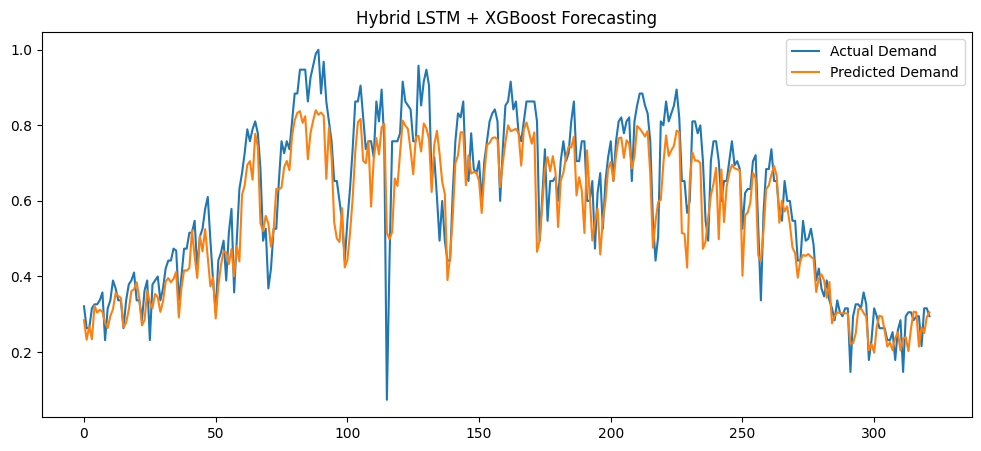

In [ ]:

df = pd.read_csv('energy_iter17.csv', parse_dates=['Date'])
df.sort_values('Date', inplace=True)

# Feature Engineering (if not already done)
df['day_of_week'] = df['Date'].dt.dayofweek


# -----------------------------
# Sequence Creation
# -----------------------------

def create_sequences(data, seq_length):
    lstm_X = []
    lstm_y = []
    xgb_features = []

    for i in range(seq_length, len(data)):
        past_seq = data[['Demand(MW)']].iloc[i-seq_length:i].values
        target = data['Demand(MW)'].iloc[i]

        features = data[[	'Temp(C)','Year',	'Month',	'Season',	'IsHoliday',	'humidity',	'feelslike', 'day_of_week']].iloc[i].values

        lstm_X.append(past_seq)
        lstm_y.append(target)
        xgb_features.append(features)

    return np.array(lstm_X), np.array(lstm_y), np.array(xgb_features)

SEQ_LENGTH = 30
lstm_X, lstm_y, xgb_feats = create_sequences(df, SEQ_LENGTH)

# Train-test split
X_train_lstm, X_test_lstm, y_train, y_test, X_train_xgb, X_test_xgb = train_test_split(
    lstm_X, lstm_y, xgb_feats, test_size=0.2, shuffle=False)

# -----------------------------
#LSTM Model
# -----------------------------

lstm_model = Sequential()
lstm_model.add(LSTM(units=64, input_shape=(SEQ_LENGTH, 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(Dense(1))  # Single value output
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.fit(X_train_lstm, y_train, epochs=20, batch_size=16, validation_split=0.1)

# Extract LSTM output (predicted embedding)
lstm_train_preds = lstm_model.predict(X_train_lstm)
lstm_test_preds = lstm_model.predict(X_test_lstm)

# -----------------------------
# Combine & Train XGBoost
# -----------------------------

X_train_final = np.concatenate([lstm_train_preds, X_train_xgb], axis=1)
X_test_final = np.concatenate([lstm_test_preds, X_test_xgb], axis=1)

xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
xgb_model.fit(X_train_final, y_train)

# -----------------------------
# Prediction
# -----------------------------

y_pred = xgb_model.predict(X_test_final)

plt.figure(figsize=(12, 5))
plt.plot(y_test, label='Actual Demand')
plt.plot(y_pred, label='Predicted Demand')
plt.title("Hybrid LSTM + XGBoost Forecasting")
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# R² Score
r2 = r2_score(y_test, y_pred)

# MAE (Mean Absolute Error)
mae = mean_absolute_error(y_test, y_pred)

# MSE (Mean Squared Error)
mse = mean_squared_error(y_test, y_pred)

# RMSE (Root Mean Squared Error)
rmse = np.sqrt(mse)

# Print Results
print("📊 Model Evaluation Metrics:")
print(f"R² Score     : {r2:.4f}")
print(f"MAE          : {mae:.4f}")
print(f"MSE          : {mse:.4f}")
print(f"RMSE         : {rmse:.4f}")


📊 Model Evaluation Metrics:
R² Score     : 0.8289
MAE          : 0.0685
MSE          : 0.0077
RMSE         : 0.0878


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


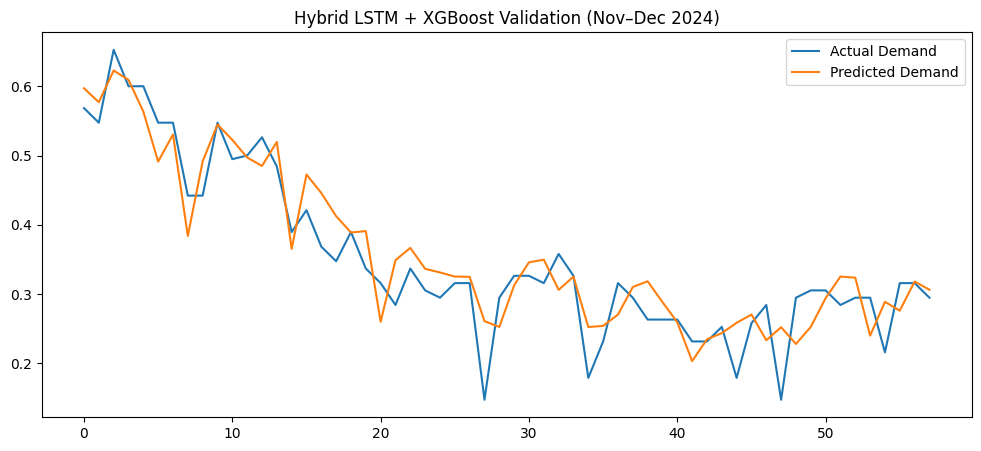

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
✅ Predicted electricity demand for 2025-01-01: 0.29 MW


In [1]:
#Model 2

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import xgboost as xgb

# -----------------------------
# Load Data
# -----------------------------
df = pd.read_csv('energy_iter17.csv', parse_dates=['Date'])
df.sort_values('Date', inplace=True)

# -----------------------------
# Feature Engineering
# -----------------------------
df['day_of_week'] = df['Date'].dt.dayofweek
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# -----------------------------
# Create Sequences
# -----------------------------
def create_sequences(data, seq_length):
    lstm_X, lstm_y, xgb_features, dates = [], [], [], []

    for i in range(seq_length, len(data)):
        past_seq = data[['Demand(MW)']].iloc[i-seq_length:i].values
        target = data['Demand(MW)'].iloc[i]
        features = data[['Temp(C)', 'Year', 'Month', 'Season', 'IsHoliday', 'humidity', 'feelslike', 'day_of_week']].iloc[i].values

        lstm_X.append(past_seq)
        lstm_y.append(target)
        xgb_features.append(features)
        dates.append(data['Date'].iloc[i])  # store the date for splitting later

    return np.array(lstm_X), np.array(lstm_y), np.array(xgb_features), np.array(dates)

SEQ_LENGTH = 30
lstm_X, lstm_y, xgb_feats, sequence_dates = create_sequences(df, SEQ_LENGTH)

# -----------------------------
# Time-Based Train/Validation Split (Option 4)
# -----------------------------
# Define cut-off dates
train_end = pd.Timestamp("2024-10-31")
valid_start = pd.Timestamp("2024-11-01")
valid_end = pd.Timestamp("2024-12-31")

# Get boolean masks
train_mask = sequence_dates <= train_end
valid_mask = (sequence_dates >= valid_start) & (sequence_dates <= valid_end)

# Split based on date masks
X_train_lstm, X_valid_lstm = lstm_X[train_mask], lstm_X[valid_mask]
X_train_xgb, X_valid_xgb = xgb_feats[train_mask], xgb_feats[valid_mask]
y_train, y_valid = lstm_y[train_mask], lstm_y[valid_mask]

# -----------------------------
# Train LSTM
# -----------------------------
lstm_model = Sequential()
lstm_model.add(LSTM(units=64, input_shape=(SEQ_LENGTH, 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.fit(X_train_lstm, y_train, epochs=20, batch_size=16, validation_split=0.1, verbose=0)

# LSTM embeddings
lstm_train_preds = lstm_model.predict(X_train_lstm)
lstm_valid_preds = lstm_model.predict(X_valid_lstm)

# -----------------------------
# Train XGBoost on top of LSTM embeddings + weather features
# -----------------------------
X_train_final = np.concatenate([lstm_train_preds, X_train_xgb], axis=1)
X_valid_final = np.concatenate([lstm_valid_preds, X_valid_xgb], axis=1)

xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
xgb_model.fit(X_train_final, y_train)

# -----------------------------
# Validate on Nov–Dec 2024
# -----------------------------
y_pred_valid = xgb_model.predict(X_valid_final)

plt.figure(figsize=(12, 5))
plt.plot(y_valid, label='Actual Demand')
plt.plot(y_pred_valid, label='Predicted Demand')
plt.title("Hybrid LSTM + XGBoost Validation (Nov–Dec 2024)")
plt.legend()
plt.show()

# -----------------------------
# ✅ Final Step: Retrain on Full Data to Predict 2025-01-01
# -----------------------------
# Recreate sequences using all data up to 2024-12-31
full_train_mask = sequence_dates <= pd.Timestamp("2024-12-31")
X_full_lstm = lstm_X[full_train_mask]
X_full_xgb = xgb_feats[full_train_mask]
y_full = lstm_y[full_train_mask]

# Retrain LSTM
lstm_model.fit(X_full_lstm, y_full, epochs=10, batch_size=16, verbose=0)
lstm_full_preds = lstm_model.predict(X_full_lstm)

# Retrain XGBoost
X_full_final = np.concatenate([lstm_full_preds, X_full_xgb], axis=1)
xgb_model.fit(X_full_final, y_full)

# Prepare input for 2025-01-01
recent_seq = df[['Demand(MW)']].iloc[-SEQ_LENGTH:].values.reshape(1, SEQ_LENGTH, 1)
recent_features = df[['Temp(C)', 'Year', 'Month', 'Season', 'IsHoliday', 'humidity', 'feelslike', 'day_of_week']].iloc[-1].values.reshape(1, -1)

lstm_embedding = lstm_model.predict(recent_seq)
final_input = np.concatenate([lstm_embedding, recent_features], axis=1)

# Predict 2025-01-01 demand
next_day_pred = xgb_model.predict(final_input)[0]
print(f"✅ Predicted electricity demand for 2025-01-01: {next_day_pred:.2f} MW")


In [2]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_valid, y_pred_valid)
rmse = np.sqrt(mean_squared_error(y_valid, y_pred_valid))
r2 = r2_score(y_valid, y_pred_valid)
mape = np.mean(np.abs((y_valid - y_pred_valid) / y_valid)) * 100

print("📊 Model Evaluation (Nov–Dec 2024):")
print(f"✅ MAE  : {mae:.2f} MW")
print(f"✅ RMSE : {rmse:.2f} MW")
print(f"✅ R²    : {r2:.4f}")
print(f"✅ MAPE : {mape:.2f}%")


📊 Model Evaluation (Nov–Dec 2024):
✅ MAE  : 0.04 MW
✅ RMSE : 0.04 MW
✅ R²    : 0.8603
✅ MAPE : 13.05%


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


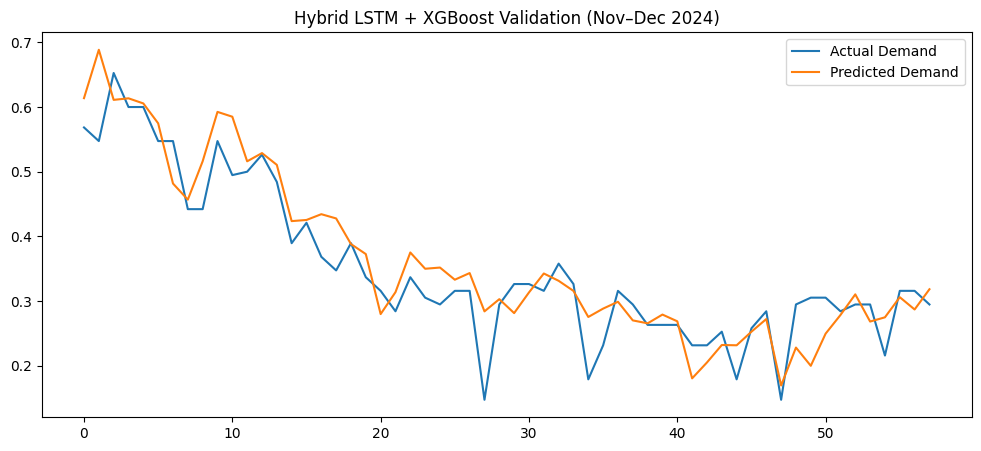

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
✅ Predicted electricity demand for 2025-01-01: 0.28 MW


In [3]:
#Model 3

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import xgboost as xgb

# -----------------------------
# Load Data
# -----------------------------
df = pd.read_csv('energy_iter17.csv', parse_dates=['Date'])
df.sort_values('Date', inplace=True)

# -----------------------------
# Feature Engineering
# -----------------------------
df['day_of_week'] = df['Date'].dt.dayofweek
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# -----------------------------
# Create Sequences (lagged features)
# -----------------------------
def create_sequences(data, seq_length):
    lstm_X, lstm_y, xgb_features, dates = [], [], [], []

    for i in range(seq_length+1, len(data)):  # start from seq_length+1 to access i-1 safely
        past_seq = data[['Demand(MW)']].iloc[i-seq_length-1:i-1].values  # past 30 days demand ending at day i-1
        target = data['Demand(MW)'].iloc[i]  # target is demand at day i

        # Use features from day i-1 (lagged by one day)
        features = data[['Temp(C)', 'Year', 'Month', 'Season', 'IsHoliday', 'humidity', 'feelslike', 'day_of_week']].iloc[i-1].values

        lstm_X.append(past_seq)
        lstm_y.append(target)
        xgb_features.append(features)
        dates.append(data['Date'].iloc[i])

    return np.array(lstm_X), np.array(lstm_y), np.array(xgb_features), np.array(dates)

SEQ_LENGTH = 30
lstm_X, lstm_y, xgb_feats, sequence_dates = create_sequences(df, SEQ_LENGTH)

# -----------------------------
# Time-Based Train/Validation Split (Option 4)
# -----------------------------
train_end = pd.Timestamp("2024-10-31")
valid_start = pd.Timestamp("2024-11-01")
valid_end = pd.Timestamp("2024-12-31")

train_mask = sequence_dates <= train_end
valid_mask = (sequence_dates >= valid_start) & (sequence_dates <= valid_end)

X_train_lstm, X_valid_lstm = lstm_X[train_mask], lstm_X[valid_mask]
X_train_xgb, X_valid_xgb = xgb_feats[train_mask], xgb_feats[valid_mask]
y_train, y_valid = lstm_y[train_mask], lstm_y[valid_mask]

# -----------------------------
# Train LSTM
# -----------------------------
lstm_model = Sequential()
lstm_model.add(LSTM(units=64, input_shape=(SEQ_LENGTH, 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.fit(X_train_lstm, y_train, epochs=20, batch_size=16, validation_split=0.1, verbose=0)

lstm_train_preds = lstm_model.predict(X_train_lstm)
lstm_valid_preds = lstm_model.predict(X_valid_lstm)

# -----------------------------
# Train XGBoost on top of LSTM embeddings + lagged weather features
# -----------------------------
X_train_final = np.concatenate([lstm_train_preds, X_train_xgb], axis=1)
X_valid_final = np.concatenate([lstm_valid_preds, X_valid_xgb], axis=1)

xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
xgb_model.fit(X_train_final, y_train)

# -----------------------------
# Validate on Nov–Dec 2024
# -----------------------------
y_pred_valid = xgb_model.predict(X_valid_final)

plt.figure(figsize=(12, 5))
plt.plot(y_valid, label='Actual Demand')
plt.plot(y_pred_valid, label='Predicted Demand')
plt.title("Hybrid LSTM + XGBoost Validation (Nov–Dec 2024)")
plt.legend()
plt.show()

# -----------------------------
# Final Step: Retrain on Full Data to Predict 2025-01-01
# -----------------------------
full_train_mask = sequence_dates <= pd.Timestamp("2024-12-31")
X_full_lstm = lstm_X[full_train_mask]
X_full_xgb = xgb_feats[full_train_mask]
y_full = lstm_y[full_train_mask]

lstm_model.fit(X_full_lstm, y_full, epochs=10, batch_size=16, verbose=0)
lstm_full_preds = lstm_model.predict(X_full_lstm)

X_full_final = np.concatenate([lstm_full_preds, X_full_xgb], axis=1)
xgb_model.fit(X_full_final, y_full)

# Prepare input for 2025-01-01 prediction
recent_seq = df[['Demand(MW)']].iloc[-SEQ_LENGTH-1:-1].values.reshape(1, SEQ_LENGTH, 1)  # last 30 days demand ending on 2024-12-31
recent_features = df[['Temp(C)', 'Year', 'Month', 'Season', 'IsHoliday', 'humidity', 'feelslike', 'day_of_week']].iloc[-1].values.reshape(1, -1)  # features of 2024-12-31 (previous day)

lstm_embedding = lstm_model.predict(recent_seq)
final_input = np.concatenate([lstm_embedding, recent_features], axis=1)

next_day_pred = xgb_model.predict(final_input)[0]
print(f"✅ Predicted electricity demand for 2025-01-01: {next_day_pred:.2f} MW")


In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_valid, y_pred_valid)
rmse = np.sqrt(mean_squared_error(y_valid, y_pred_valid))
r2 = r2_score(y_valid, y_pred_valid)
mape = np.mean(np.abs((y_valid - y_pred_valid) / y_valid)) * 100

print("📊 Model Evaluation (Nov–Dec 2024):")
print(f"✅ MAE  : {mae:.2f} MW")
print(f"✅ RMSE : {rmse:.2f} MW")
print(f"✅ R²    : {r2:.4f}")
print(f"✅ MAPE : {mape:.2f}%")

📊 Model Evaluation (Nov–Dec 2024):
✅ MAE  : 0.04 MW
✅ RMSE : 0.05 MW
✅ R²    : 0.8350
✅ MAPE : 12.49%


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


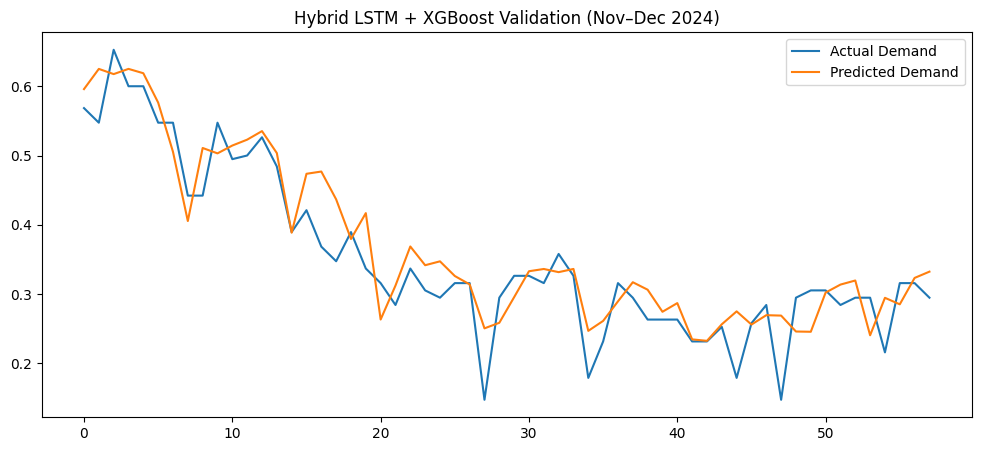

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
✅ Predicted electricity demand for 2025-01-01: 0.25 MW


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import xgboost as xgb

# -----------------------------
# Load Data
# -----------------------------
df = pd.read_csv('energy_iter17.csv', parse_dates=['Date'])
df.sort_values('Date', inplace=True)

# -----------------------------
# Feature Engineering
# -----------------------------
df['day_of_week'] = df['Date'].dt.dayofweek
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# -----------------------------
# Create Sequences with lagged weather and current calendar/holiday
# -----------------------------
def create_sequences(data, seq_length):
    lstm_X, lstm_y, xgb_features, dates = [], [], [], []

    for i in range(seq_length, len(data)):
        past_seq = data[['Demand(MW)']].iloc[i-seq_length:i].values
        target = data['Demand(MW)'].iloc[i]

        # Lagged weather features from day i-1
        lagged_weather = data[['Temp(C)', 'humidity', 'feelslike']].iloc[i-1].values

        # Current day calendar and holiday features from day i
        current_day_info = data[['Year', 'Month', 'Season', 'IsHoliday', 'day_of_week']].iloc[i].values

        # Combine features
        features = np.concatenate([lagged_weather, current_day_info])

        lstm_X.append(past_seq)
        lstm_y.append(target)
        xgb_features.append(features)
        dates.append(data['Date'].iloc[i])  # keep date for splitting

    return np.array(lstm_X), np.array(lstm_y), np.array(xgb_features), np.array(dates)

SEQ_LENGTH = 30
lstm_X, lstm_y, xgb_feats, sequence_dates = create_sequences(df, SEQ_LENGTH)

# -----------------------------
# Time-Based Train/Validation Split (Option 4)
# -----------------------------
train_end = pd.Timestamp("2024-10-31")
valid_start = pd.Timestamp("2024-11-01")
valid_end = pd.Timestamp("2024-12-31")

train_mask = sequence_dates <= train_end
valid_mask = (sequence_dates >= valid_start) & (sequence_dates <= valid_end)

X_train_lstm, X_valid_lstm = lstm_X[train_mask], lstm_X[valid_mask]
X_train_xgb, X_valid_xgb = xgb_feats[train_mask], xgb_feats[valid_mask]
y_train, y_valid = lstm_y[train_mask], lstm_y[valid_mask]

# -----------------------------
# Train LSTM
# -----------------------------
lstm_model = Sequential()
lstm_model.add(LSTM(units=64, input_shape=(SEQ_LENGTH, 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.fit(X_train_lstm, y_train, epochs=20, batch_size=16, validation_split=0.1, verbose=0)

# Get LSTM embeddings
lstm_train_preds = lstm_model.predict(X_train_lstm)
lstm_valid_preds = lstm_model.predict(X_valid_lstm)

# -----------------------------
# Train XGBoost on top of LSTM embeddings + features
# -----------------------------
X_train_final = np.concatenate([lstm_train_preds, X_train_xgb], axis=1)
X_valid_final = np.concatenate([lstm_valid_preds, X_valid_xgb], axis=1)

xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
xgb_model.fit(X_train_final, y_train)

# -----------------------------
# Validate on Nov–Dec 2024
# -----------------------------
y_pred_valid = xgb_model.predict(X_valid_final)

plt.figure(figsize=(12, 5))
plt.plot(y_valid, label='Actual Demand')
plt.plot(y_pred_valid, label='Predicted Demand')
plt.title("Hybrid LSTM + XGBoost Validation (Nov–Dec 2024)")
plt.legend()
plt.show()

# -----------------------------
# Final Step: Retrain on Full Data to Predict 2025-01-01
# -----------------------------
full_train_mask = sequence_dates <= pd.Timestamp("2024-12-31")
X_full_lstm = lstm_X[full_train_mask]
X_full_xgb = xgb_feats[full_train_mask]
y_full = lstm_y[full_train_mask]

lstm_model.fit(X_full_lstm, y_full, epochs=10, batch_size=16, verbose=0)
lstm_full_preds = lstm_model.predict(X_full_lstm)

X_full_final = np.concatenate([lstm_full_preds, X_full_xgb], axis=1)
xgb_model.fit(X_full_final, y_full)

# Prepare input for 2025-01-01 prediction
# Use last SEQ_LENGTH days demand sequence for LSTM input
recent_seq = df[['Demand(MW)']].iloc[-SEQ_LENGTH:].values.reshape(1, SEQ_LENGTH, 1)

# Lagged weather features for 2024-12-31 (previous day of 2025-01-01)
lagged_weather_2024_12_31 = df[['Temp(C)', 'humidity', 'feelslike']].iloc[-1].values.reshape(1, -1)

# Current day calendar/holiday features for 2025-01-01 (you must prepare or have this row)
# Here you should manually create a row or dictionary with these known features for 2025-01-01
# Example (fill with your known info):
import datetime
date_2025_01_01 = pd.Timestamp("2025-01-01")
current_day_info_2025 = np.array([
    date_2025_01_01.year,
    date_2025_01_01.month,
    # season for January? let's assume winter=1, adjust accordingly:
    1,  # Season
    1,  # IsHoliday? 1 if yes else 0, adjust accordingly
    date_2025_01_01.dayofweek
]).reshape(1, -1)

# Combine lagged weather + current day calendar/holiday for 2025-01-01
final_features_2025 = np.concatenate([lagged_weather_2024_12_31, current_day_info_2025], axis=1)

# Get LSTM embedding for last sequence
lstm_embedding = lstm_model.predict(recent_seq)

# Combine LSTM embedding + features
final_input = np.concatenate([lstm_embedding, final_features_2025], axis=1)

# Predict demand
next_day_pred = xgb_model.predict(final_input)[0]
print(f"✅ Predicted electricity demand for 2025-01-01: {next_day_pred:.2f} MW")


In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_valid, y_pred_valid)
rmse = np.sqrt(mean_squared_error(y_valid, y_pred_valid))
r2 = r2_score(y_valid, y_pred_valid)
mape = np.mean(np.abs((y_valid - y_pred_valid) / y_valid)) * 100

print("📊 Model Evaluation (Nov–Dec 2024):")
print(f"✅ MAE  : {mae:.2f} MW")
print(f"✅ RMSE : {rmse:.2f} MW")
print(f"✅ R²    : {r2:.4f}")
print(f"✅ MAPE : {mape:.2f}%")

📊 Model Evaluation (Nov–Dec 2024):
✅ MAE  : 0.04 MW
✅ RMSE : 0.05 MW
✅ R²    : 0.8490
✅ MAPE : 12.80%


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


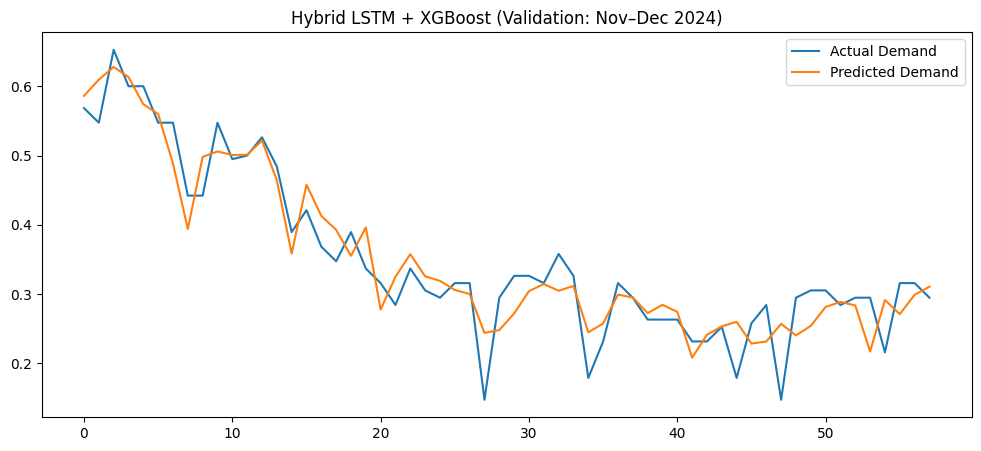

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
✅ Predicted electricity demand for 2025-01-01: 0.23 MW


In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import xgboost as xgb
import matplotlib.pyplot as plt

# -----------------------------
# Load and Prepare Data
# -----------------------------
df = pd.read_csv('energy_iter17.csv', parse_dates=['Date'])
df.sort_values('Date', inplace=True)

# Feature Engineering
df['day_of_week'] = df['Date'].dt.dayofweek
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# Define Season feature
def get_season(month):
    if month in [12, 1, 2]:
        return 0  # Winter
    elif month in [3, 4, 5]:
        return 1  # Spring
    elif month in [6, 7, 8]:
        return 2  # Summer
    else:
        return 3  # Fall

df['Season'] = df['Month'].apply(get_season)

# -----------------------------
# Sequence Creation Function
# -----------------------------
def create_sequences(data, demand_seq_len=30, weather_seq_len=5):
    lstm_X, lstm_y, xgb_features, dates = [], [], [], []

    for i in range(demand_seq_len, len(data)):
        if i - weather_seq_len < 0:
            continue

        # Past 30 days of demand
        demand_seq = data[['Demand(MW)']].iloc[i - demand_seq_len:i].values

        # Past 5 days of weather
        weather_features = []
        for j in range(weather_seq_len):
            w = data[['Temp(C)', 'humidity', 'feelslike']].iloc[i - j - 1].values
            weather_features.extend(w)

        # Current day's known calendar features (including IsHoliday)
        time_features = data[['Year', 'Month', 'Season', 'day_of_week', 'IsHoliday']].iloc[i].values

        features = np.concatenate([weather_features, time_features])
        target = data['Demand(MW)'].iloc[i]

        lstm_X.append(demand_seq)
        xgb_features.append(features)
        lstm_y.append(target)
        dates.append(data['Date'].iloc[i])

    return np.array(lstm_X), np.array(lstm_y), np.array(xgb_features), np.array(dates)

# -----------------------------
# Create Sequences
# -----------------------------
SEQ_LENGTH = 30
WEATHER_SEQ_LENGTH = 5
lstm_X, lstm_y, xgb_feats, sequence_dates = create_sequences(df, SEQ_LENGTH, WEATHER_SEQ_LENGTH)

# -----------------------------
# Time-Based Train/Validation Split
# -----------------------------
train_end = pd.Timestamp("2024-10-31")
valid_start = pd.Timestamp("2024-11-01")
valid_end = pd.Timestamp("2024-12-31")

train_mask = sequence_dates <= train_end
valid_mask = (sequence_dates >= valid_start) & (sequence_dates <= valid_end)

X_train_lstm, X_valid_lstm = lstm_X[train_mask], lstm_X[valid_mask]
X_train_xgb, X_valid_xgb = xgb_feats[train_mask], xgb_feats[valid_mask]
y_train, y_valid = lstm_y[train_mask], lstm_y[valid_mask]

# -----------------------------
# Train LSTM Model
# -----------------------------
lstm_model = Sequential()
lstm_model.add(LSTM(units=64, input_shape=(SEQ_LENGTH, 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.fit(X_train_lstm, y_train, epochs=20, batch_size=16, validation_split=0.1, verbose=0)

# LSTM Embeddings
lstm_train_embed = lstm_model.predict(X_train_lstm)
lstm_valid_embed = lstm_model.predict(X_valid_lstm)

# -----------------------------
# Train XGBoost on Top of LSTM + Features
# -----------------------------
X_train_final = np.concatenate([lstm_train_embed, X_train_xgb], axis=1)
X_valid_final = np.concatenate([lstm_valid_embed, X_valid_xgb], axis=1)

xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
xgb_model.fit(X_train_final, y_train)

# -----------------------------
# Validate on Nov–Dec 2024
# -----------------------------
y_pred = xgb_model.predict(X_valid_final)

plt.figure(figsize=(12, 5))
plt.plot(y_valid, label='Actual Demand')
plt.plot(y_pred, label='Predicted Demand')
plt.title("Hybrid LSTM + XGBoost (Validation: Nov–Dec 2024)")
plt.legend()
plt.show()

# -----------------------------
# Final Retrain and Predict 2025-01-01
# -----------------------------
full_mask = sequence_dates <= pd.Timestamp("2024-12-31")
X_full_lstm = lstm_X[full_mask]
X_full_xgb = xgb_feats[full_mask]
y_full = lstm_y[full_mask]

# Retrain LSTM
lstm_model.fit(X_full_lstm, y_full, epochs=10, batch_size=16, verbose=0)
lstm_embed_full = lstm_model.predict(X_full_lstm)

# Retrain XGBoost
X_full_final = np.concatenate([lstm_embed_full, X_full_xgb], axis=1)
xgb_model.fit(X_full_final, y_full)

# -----------------------------
# Predict for 2025-01-01
# -----------------------------
recent_seq = df[['Demand(MW)']].iloc[-SEQ_LENGTH:].values.reshape(1, SEQ_LENGTH, 1)

recent_weather = []
for j in range(WEATHER_SEQ_LENGTH):
    w = df[['Temp(C)', 'humidity', 'feelslike']].iloc[-j - 1].values
    recent_weather.extend(w)

# Known calendar values for Jan 1, 2025
future_date = pd.Timestamp("2025-01-01")
future_time = [
    future_date.year,
    future_date.month,
    get_season(future_date.month),
    future_date.dayofweek,
    1  # IsHoliday (manually marked for Jan 1)
]

final_features = np.concatenate([recent_weather, future_time]).reshape(1, -1)
lstm_embed = lstm_model.predict(recent_seq)
final_input = np.concatenate([lstm_embed, final_features], axis=1)
next_day_pred = xgb_model.predict(final_input)[0]

print(f"✅ Predicted electricity demand for 2025-01-01: {next_day_pred:.2f} MW")


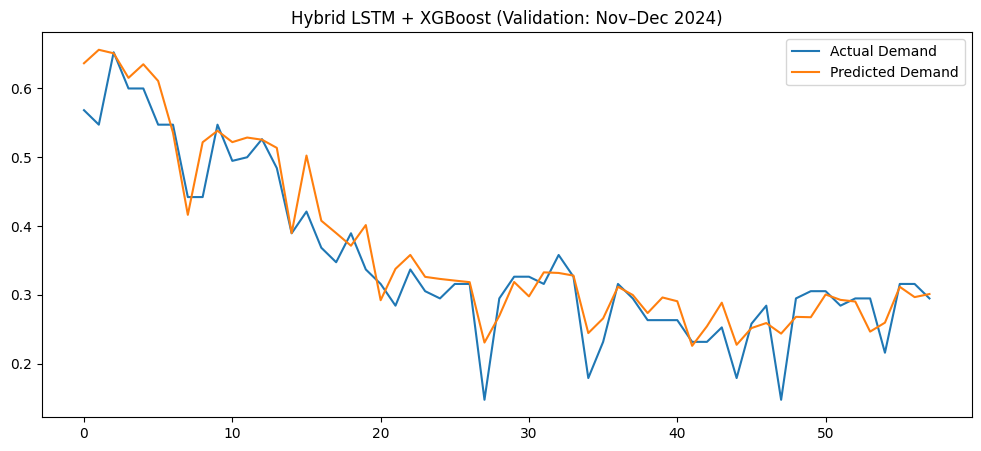

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
y_pred = xgb_model.predict(X_valid_final)

plt.figure(figsize=(12, 5))
plt.plot(y_valid, label='Actual Demand')
plt.plot(y_pred, label='Predicted Demand')
plt.title("Hybrid LSTM + XGBoost (Validation: Nov–Dec 2024)")
plt.legend()
plt.show()


In [21]:
# -----------------------------
# 📊 Model Evaluation
# -----------------------------
mae = mean_absolute_error(y_valid, y_pred)
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
mape = mean_absolute_percentage_error(y_valid, y_pred) * 100

print(f"📈 Model Evaluation on Validation Set (Nov–Dec 2024):")
print(f"✅ MAE  : {mae:.2f} MW")
print(f"✅ RMSE : {rmse:.2f} MW")
print(f"✅ MAPE : {mape:.2f}%")
print(f"✅ R²    : {r2:.4f}")


📈 Model Evaluation on Validation Set (Nov–Dec 2024):
✅ MAE  : 0.03 MW
✅ RMSE : 0.04 MW
✅ MAPE : 10.16%
✅ R²    : 0.8490


In [22]:
train_pred = xgb_model.predict(X_train_final)

train_mae = mean_absolute_error(y_train, train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
train_mape = mean_absolute_percentage_error(y_train, train_pred) * 100

print(f"\n🧪 Training Set Evaluation:")
print(f"MAE  : {train_mae:.2f} MW")
print(f"RMSE : {train_rmse:.2f} MW")
print(f"✅ R²    : {r2:.4f}")



🧪 Training Set Evaluation:
MAE  : 0.03 MW
RMSE : 0.04 MW
✅ R²    : 0.8490
